# Growth model

Here i simulate the basic growth model used by Charnov ect...

$$
\frac{dM}{dt} = aM^{\beta} - bM - cM^{\gamma}
$$

where $aM^{\beta}$ is energy intake with its mass scaling exponent, $bM$ is maintenece metabolism and $cM^{\gamma}$ is reproductive output.

the fitness ($R_0$) of an individual growing according to the model above can be obtained by integrating their reproductive output over time, including thier mortaility L(M):

$$
R_0 = \int_0^\infty cM^{\beta} L(M,t) dt
$$

This mortality function is set to an exponential decay function here:

$$
L(M,t) = e^{-\lambda Mt}
$$

where $\lambda$ is a rate parameter controling the rate at which the likelyhood of survival decreases.

I also consider the "switching on" of reproduction at some mass $M_{\alpha}$. This occurs instantly with a piecewise funtion for growth. 

In [1]:
using Pkg
# import Pkg; Pkg.add("DifferentialEquations")
# import Pkg; Pkg.add("DiffEqCallbacks")
# import Pkg; Pkg.add("Plots")
# Pkg.add("PGFPlots")
Pkg.activate("..")

using DifferentialEquations, DiffEqCallbacks, Plots

┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1186
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for SteadyStateDiffEq [9672c7b4-1e72-59bd-8a11-6ac3964bc41f]
│   exception = Required dependency DiffEqCallbacks [459566f4-90b8-5000-8ac3-15dfb0a30def] failed to load from a cache file.
└ @ Base loading.jl:969


In [200]:
# Pkg.rm("pgfplots")

┌ Warning: `pgfplots` not in project, ignoring
└ @ Pkg.Operations /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/Pkg/src/Operations.jl:1131
┌ Info: No changes
└ @ Pkg.Operations /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/Pkg/src/Operations.jl:1139


In [2]:
function dM(dM,M,p,t)
    intak = p[:a_0] * (abs(M[1]) ^ p[:a_b])
    maint = p[:b_0] * (abs(M[1]) ^ p[:b_b])
    
#     if M[1] < p[:Ma] 
#         repro = 0.0
    if t < p[:Alph] 
        repro = 0.0
    else
        repro = p[:c_0] * (abs(M[1]) ^ p[:c_b])
        
        end
        
    dM[1] = intak - maint - repro
    dM[2] = repro * exp(-(p[:k]+p[:Z])*(t-p[:Alph]))
    
#     if M[1] + dM[1] < 0
#         dM[1] = -M[1]
#     end
    
end

dM (generic function with 1 method)

In [97]:
hypothetical_starting_mass = 0.1
hypothetical_asymptotic_mass = 25000
hypothetical_starting_reproduction = 0 #c * (hypothetical_starting_mass)^ rho
a = 0.15; a_b = 1.0
b = a/(hypothetical_asymptotic_mass^0.25)
c = 0.1 # West et al. assume 0.1 from Peters
alpha = 200
p = Dict([(:a_0,a),(:a_b,a_b),
          (:b_0,b),(:b_b,1.0),
          (:c_0,c),(:c_b,1.0),
          (:Alph,alpha),
          (:k,0.01),(:Z,2/alpha)])

M0 = [hypothetical_starting_mass, hypothetical_starting_reproduction]
# M0 = [1.,0.0]
tspan = (0.0,1e4)
prob = ODEProblem(dM,M0,tspan,p)
sol = solve(prob,Rosenbrock23())

# plot(hcat(sol.u...)')
plot(sol)

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/lvassor/.julia/packages/DiffEqBase/LCorD/src/integrator_interface.jl:150


In [92]:
M_alph = sol(p[:Alph])[1]

ErrorException: Solution interpolation cannot extrapolate past the final timepoint. Either solve on a longer timespan or use the local extrapolation from the integrator interface.

In [36]:
# sol.u

In [2]:
resolution = 100
c_vec = range(0.001,0.32,length = resolution)
c_b_vec = range(0.001,1.25,length = resolution)
results = Array{Float64,2}(undef,resolution,resolution)

tspan = (0.0,1e6)

for i in 1:resolution
    c_0 = c_vec[i]
    for j in 1:resolution
        c_b = c_b_vec[j]
        p = Dict([(:a_0,a),(:a_b,a_b),
          (:b_0,b),(:b_b,1.0),
          (:c_0,c_0),(:c_b,c_b),
          (:Alph,0.0),
          (:k,0.1),(:Z,0.9)])
        prob = ODEProblem(dM,M0,tspan,p)
        sol = solve(prob,Rosenbrock23())
        results[i,j] = sol[end][1]
    end
end

UndefVarError: UndefVarError: a not defined

In [3]:
print(c_vec)

0.001:0.0032222222222222222:0.32

In [47]:
results

100×100 Array{Float64,2}:
 24999.9       24999.9       24999.9       …  13291.1      12473.5    
 24999.7       24999.7       24999.7           5193.78      4661.83   
 24999.6       24999.5       24999.4           2874.21      2548.9    
 24999.4       24999.3       24999.2           1854.6       1637.96   
 24999.2       24999.1       24999.0           1307.1       1153.15   
 24999.0       24998.9       24998.7       …    976.013      861.301  
 24998.8       24998.7       24998.5            759.231      670.653  
 24998.6       24998.5       24998.3            608.945      538.625  
 24998.5       24998.3       24998.0            500.158      443.084  
 24998.3       24998.1       24997.8            418.699      371.531  
 24998.1       24997.8       24997.5       …    356.017      316.444  
 24997.9       24997.6       24997.3            306.686      273.06   
 24997.7       24997.4       24997.1            267.124      238.239  
     ⋮                                     ⋱       

In [88]:
feas = results .> M_alph # matrix of feasible growth curves where asmyptotic size is larger than mass a maturity (i.e.) those curves with no shrinking

heatmap(feas) #, colormap=ColorMaps.Named("Jet"))
savefig("../Results/feasible.pdf") # Saves the plot from p as a .pdf vector graphic

In [83]:
results = Array{Any,2}(undef,resolution,resolution)

M0 = [hypothetical_starting_mass, hypothetical_starting_reproduction]
tspan = (0.0,1e6)
alpha=300
for i in 1:resolution
    c_0 = c_vec[i]
    for j in 1:resolution
        c_b = c_b_vec[j]
        p = Dict([(:a_0,a),(:a_b,a_b),
          (:b_0,b),(:b_b,1.0),
          (:c_0,c_0),(:c_b,c_b),
          (:Alph,alpha),
          (:k,0.01),(:Z,2/alpha)])
        prob = ODEProblem(dM,M0,tspan,p)
        sol = solve(prob,Rosenbrock23())
        results[i,j] = sol
    end
end

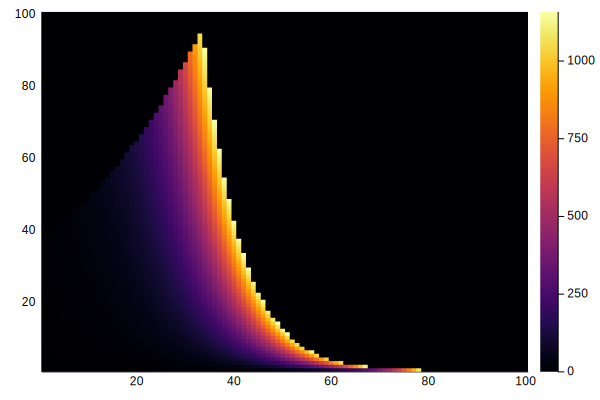

In [84]:
x = [i.u[end][2] for i = results]

heatmap(x .* feas)
# findmax(x .* feas) #, xlabel = "c value", ylabel = "rho value")
# savefig("../Results/heatmap.pdf") # Saves the plot from p as a .pdf vector graphic

In [143]:
results[i,j](p[:Alph])

UndefVarError: UndefVarError: i not defined

In [144]:
plot(hcat(results[19,20].(results[19,20], Val{1})...)')

UndefRefError: UndefRefError: access to undefined reference

In [145]:
x = rand(12)

sqrt.(x)

12-element Array{Float64,1}:
 0.8883191641572115 
 0.6204402154769814 
 0.9868544018312602 
 0.7956579358471734 
 0.2627620234950214 
 0.45124408993633974
 0.9596178530708627 
 0.7871748519655691 
 0.28833758309445234
 0.5772193550885569 
 0.5066849450284645 
 0.6847248378757445 

In [146]:
N_sim = 100
M_eq = 4000
results = Array{Float64,2}(undef,N_sim,N_sim)

a_vec = range(0,maximum(M_eq)+1,length = N_sim)

for i = 1:N_sim
    for j = 1:N_sim
        if a_vec[i] <= M_eq[j]
            p = Dict([(:a_0,1.0),(:a_b,.75),
              (:b_0,0.1),(:b_b,1.0),
              (:c_0,0.6),(:c_b,c_b_vec[j]),
              (:L,0.1),(:Ma,a_vec[i])])
            
            prob = ODEProblem(dM,M0,tspan,p)
            sol = solve(prob,AutoTsit5(Rosenbrock23()),callback = cb)
            
            results[i,j] = sol[2,end]
        else
            results[i,j] = 0.0
        end
        
    
    end
end

heatmap(c_b_vec,a_vec,results)

KeyError: KeyError: key :Alph not found

In [147]:
p = Dict([(:a_0,1.0),(:a_b,.75),
          (:b_0,0.1),(:b_b,1.0),
          (:c_0,0.1),(:c_b,1.0),
          (:L,1),(:Alph,20)])
M0 = [1.,0.0]
tspan = (0.0,10)
prob = ODEProblem(dM,M0,tspan,p)
cb = CallbackSet(TerminateSteadyState())
sol = solve(prob,Rosenbrock23(),callback = cb)

plot(sol)
plot!(sol.t,1 .* exp.(-sol.t / p[:L] ))

KeyError: KeyError: key :k not found